In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('SP23_Cleaned Data.xlsx')

In [3]:
df.head()

,Hour,Date,Demand
0,8,2023-02-06,297
1,9,2023-02-06,254
2,10,2023-02-06,232
3,11,2023-02-06,180
4,12,2023-02-06,118


In [4]:
df.shape

(720, 3)

In [5]:
df.isnull().sum()

Hour      0
Date      0
Demand    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Hour    720 non-null    int64         
 1   Date    720 non-null    datetime64[ns]
 2   Demand  720 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 17.0 KB


In [7]:
# Convert Date to datetime format

df['Date'] = pd.to_datetime(df['Date'])

In [8]:
# Extract features from Date

df['Month'] = df['Date'].dt.month
df[['Year', 'WeekofYear', 'DayofWeek']] = df['Date'].dt.isocalendar()
df['DayofMonth'] = df['Date'].dt.day
df['DayofYear'] = df['Date'].dt.dayofyear

In [9]:
df[['Year', 'WeekofYear', 'DayofWeek']] = df[['Year', 'WeekofYear', 'DayofWeek']].astype(int)

In [10]:
df.head(3)

,Hour,Date,Demand,Month,Year,WeekofYear,DayofWeek,DayofMonth,DayofYear
0,8,2023-02-06,297,2,2023,6,1,6,37
1,9,2023-02-06,254,2,2023,6,1,6,37
2,10,2023-02-06,232,2,2023,6,1,6,37


In [11]:
# Create new feature Time for easier visualization

df['Time'] = df['Date'].astype(str) + ' ' + df['Hour'].astype(str) 

In [12]:
df.head()

,Hour,Date,Demand,Month,Year,WeekofYear,DayofWeek,DayofMonth,DayofYear,Time
0,8,2023-02-06,297,2,2023,6,1,6,37,2023-02-06 8
1,9,2023-02-06,254,2,2023,6,1,6,37,2023-02-06 9
2,10,2023-02-06,232,2,2023,6,1,6,37,2023-02-06 10
3,11,2023-02-06,180,2,2023,6,1,6,37,2023-02-06 11
4,12,2023-02-06,118,2,2023,6,1,6,37,2023-02-06 12


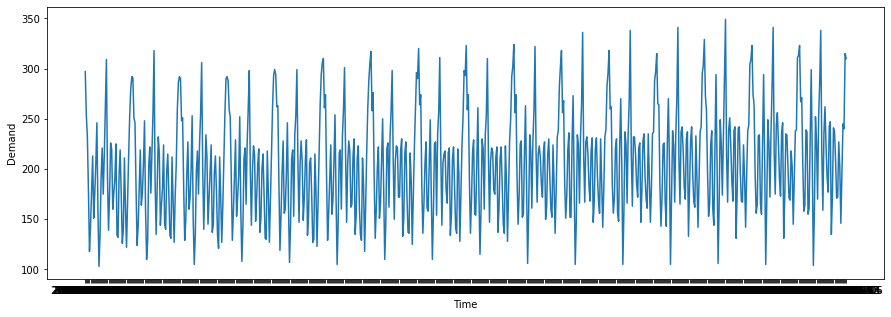

In [13]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Time', y='Demand', data=df)
plt.ylabel('Demand')

plt.show()

In [14]:
# Pop OrderDate column

date_popped = df.pop('Date')
time_popped = df.pop('Time')

In [15]:
# Train/Test Split

train = df[:630]
test = df[630:]

print(len(train))
print(len(test))

630
90


## Build Forecast Model

In [16]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance

In [17]:
X_train = train.drop('Demand', axis=1)
y_train = train['Demand']

X_test = test.drop('Demand', axis=1)
y_test = test['Demand']

In [18]:
reg = xgb.XGBRegressor(
    n_estimators=500,
    early_stopping_rounds=50,
    learning_rate=0.01)

model = reg.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False)

In [19]:
test['Prediction'] = reg.predict(X_test)

In [20]:
df_pred = df.merge(test['Prediction'], how='left', left_index=True, right_index=True)

In [30]:
prediction = df_pred.head().append(df_pred.tail())

In [31]:
prediction.head().append(prediction.tail())

,Hour,Demand,Month,Year,WeekofYear,DayofWeek,DayofMonth,DayofYear,Prediction
0,8,297,2,2023,6,1,6,37,NaN
1,9,254,2,2023,6,1,6,37,NaN
2,10,232,2,2023,6,1,6,37,NaN
3,11,180,2,2023,6,1,6,37,NaN
4,12,118,2,2023,6,1,6,37,NaN
715,12,195,5,2023,21,5,26,146,183.345840
716,13,245,5,2023,21,5,26,146,234.429672
717,14,240,5,2023,21,5,26,146,248.587982
718,15,315,5,2023,21,5,26,146,297.379456
719,16,310,5,2023,21,5,26,146,297.641693


In [33]:
# prediction.to_excel('SP23_Prediction.xlsx')

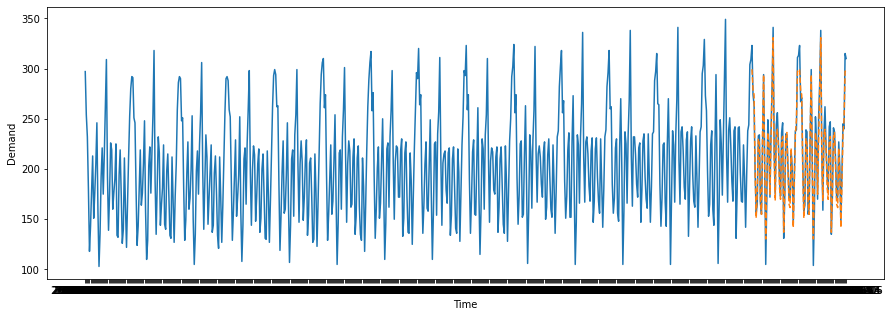

In [22]:
plt.figure(figsize=(15,5))

sns.lineplot(x=time_popped, y='Demand', data=df) # Actual number
sns.lineplot(x=time_popped, y='Prediction', data=df_pred, ls='--') # Prediction number
plt.ylabel('Demand')

plt.show()

## Model Evaluation

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
mean_squared_error(y_true = test['Demand'],
                   y_pred = test['Prediction'])

117.56640968895776

In [25]:
mean_absolute_error(y_true = test['Demand'],
                    y_pred = test['Prediction'])

8.85898929172092

In [26]:
# Calculates MAPE given y_true and y_pred

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
mean_absolute_percentage_error(y_true = test['Demand'],
                               y_pred = test['Prediction'])

4.336771863385857

In [29]:
df_pred['Prediction'].mad()

39.71575927734375